# Prediction Model #2 - Random Forest Model

## 1. Setup & Data Loading

### 1.1 Load Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape, \
                            mean_squared_error as mse, \
                            mean_absolute_error as mae, \
                            r2_score as r2

#### 1.2 Load Datasets

In [23]:
# Load datasets
df = pd.read_csv('../final dataset/Ventolin_df.csv', index_col='Unnamed: 0')
df24 = pd.read_csv('../final dataset/Ventolin2024_df.csv', index_col='Unnamed: 0')

## 2. Data Preprocessing

### 2.1 Parse Dates

In [24]:
# Define date parsing function
def parse_date(date_str):
    date_str = str(date_str).split('.')[0]
    if len(date_str) == 6:
        return pd.to_datetime(date_str, format='%Y%m')
    elif len(date_str) == 8:
        return pd.to_datetime(date_str, format='%Y%m%d')
    else:
        return pd.NaT
    
# Apply date parsing to main dataframe
df['rept_dt'] = df['rept_dt'].apply(parse_date)
if df['rept_dt'].isnull().any():
    print("Some dates could not be parsed in df")

df = df.set_index('rept_dt')


# Apply date parsing to 2024 dataframe
df24['rept_dt'] = df24['rept_dt'].apply(parse_date)
if df24['rept_dt'].isnull().any():
    print("Some dates could not be parsed in df24")

# set index
df24 = df24.set_index('rept_dt')

Some dates could not be parsed in df


### 2.2 Aggregate Data

In [25]:
# Aggregate main data by month
df_grouped = df.groupby(pd.Grouper(freq='M')).size()
df_grouped = df_grouped.asfreq('M').fillna(0)
df_grouped = df_grouped.loc['2013':'2023']

# Aggregate 2024 data by month (January to June)
df24_grouped = df24.groupby(pd.Grouper(freq='M')).size().asfreq('M').fillna(0)
df24_grouped = df24_grouped.loc['2024-01':'2024-06']

/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_88036/3918713454.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(freq='M')).size()
/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_88036/3918713454.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df_grouped.asfreq('M').fillna(0)
/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_88036/3918713454.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df24_grouped = df24.groupby(pd.Grouper(freq='M')).size().asfreq('M').fillna(0)
/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_88036/3918713454.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df24_grouped = df24.groupby(pd.Grouper(freq='M')).size().asfreq('M').fillna(0)


## 3. Feature Engineering

### 3.1 Create Lag Features

In [26]:
# Feature Engineering
df_features = pd.DataFrame(df_grouped)
df_features.columns = ['AEs']

lag_range = 108

# Create lag features
for lag in range(1, lag_range):
    df_features[f'lag_{lag}'] = df_features['AEs'].shift(lag)

# Combine main data and partial 2024 data for full feature set
combined = pd.concat([df_grouped, df24_grouped])
df_features_full = pd.DataFrame(combined)
df_features_full.columns = ['AEs']

# Create lag features on the combined data
for lag in range(1, lag_range):
    df_features_full[f'lag_{lag}'] = df_features_full['AEs'].shift(lag)

# Drop rows with NaN values
df_features_full = df_features_full.dropna()

/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_88036/1834974320.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'lag_{lag}'] = df_features['AEs'].shift(lag)
/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_88036/1834974320.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_features[f'lag_{lag}'] = df_features['AEs'].shift(lag)
/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_88036/1834974320.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result 

### 3.2 Split Data - Training & Validation Sets

In [27]:
# Define features and target
X = df_features_full.drop('AEs', axis=1)
y = df_features_full['AEs']

# Define split dates
train_end = '2022-12-31'
validation_start = '2023-01-31'
validation_end = '2023-12-31'
partial_2024_start = '2024-01-31'
partial_2024_end = '2024-06-30'

# Split into training, validation, and partial 2024 sets
X_train = X.loc[:train_end]
y_train = y.loc[:train_end]

X_validation = X.loc[validation_start:validation_end]
y_validation = y.loc[validation_start:validation_end]

X_partial_2024 = X.loc[partial_2024_start:partial_2024_end]
y_partial_2024 = y.loc[partial_2024_start:partial_2024_end]

## 4. Model Training & Evaluation

### 4.1 Training Random Forest Model - 1000 Trees

In [28]:
# Train Random Forest Model
Trees = 1000
rf_model_1000 = RandomForestRegressor(n_estimators=Trees, random_state=42)
rf_model_1000.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [29]:
# Evaluate forecast on partial 2024 data (January to June) for 1000 Trees
y_pred_partial_2024 = rf_model_1000.predict(X_partial_2024)

# Evaluation Metrics for Partial 2024
mae_partial_2024 = mae(y_partial_2024, y_pred_partial_2024)
rmse_partial_2024 = np.sqrt(mse(y_partial_2024, y_pred_partial_2024))
mape_partial_2024 = mape(y_partial_2024, y_pred_partial_2024)
r2_partial_2024 = r2(y_partial_2024, y_pred_partial_2024)

# Display Evaluation Metrics
print(f"Random Forest Evaluation Metrics for 2024 with {Trees} Trees:")
print(f"MAE: {mae_partial_2024:.2f}")
print(f"RMSE: {rmse_partial_2024:.2f}")
print(f"MAPE: {mape_partial_2024:.2f}%")
print(f"R^2: {r2_partial_2024:.2f}")



Random Forest Evaluation Metrics for 2024 with 1000 Trees:
MAE: 14.18
RMSE: 17.22
MAPE: 7.27%
R^2: -1.45


### 4.2 Visualizations - 1000 Trees

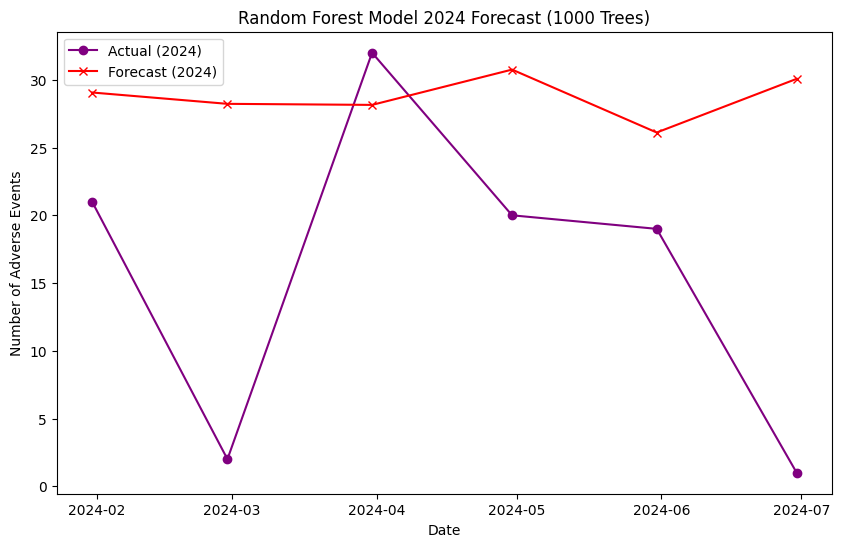

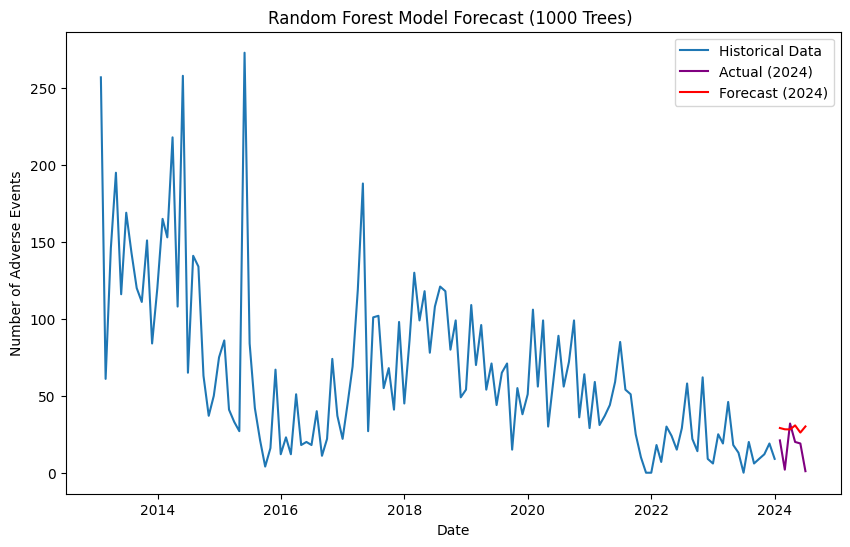

In [30]:
# Plot Actual vs Predicted for Partial 2024
plt.figure(figsize=(10, 6))
plt.plot(y_partial_2024.index, y_partial_2024, label='Actual (2024)', marker='o', color='purple')
plt.plot(y_partial_2024.index, y_pred_partial_2024, label='Forecast (2024)', marker='x', color='red')
plt.title(f'Random Forest Model 2024 Forecast ({Trees} Trees)')
plt.xlabel('Date')
plt.ylabel('Number of Adverse Events')
plt.legend()
plt.show()

# Visualize Overall Data with Partial 2024 Forecast
plt.figure(figsize=(10, 6))
plt.plot(df_grouped, label='Historical Data')
plt.plot(df24_grouped, label='Actual (2024)', color='purple')
plt.plot(y_partial_2024.index, y_pred_partial_2024, label='Forecast (2024)', color='red')
plt.title(f'Random Forest Model Forecast ({Trees} Trees) ')
plt.xlabel('Date')
plt.ylabel('Number of Adverse Events')
plt.legend()
plt.show()

### 4.3 Training Random Forest Model - 100 Trees

In [31]:
# Train Random Forest Model
Trees = 100  #100 Trees is default
rf_model_100 = RandomForestRegressor(n_estimators=Trees, random_state=42)
rf_model_100.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [32]:
# Evaluate forecast on partial 2024 data (January to June) for 1000 Trees
y_pred_partial_2024 = rf_model_100.predict(X_partial_2024)

# Evaluation Metrics for Partial 2024
mae_partial_2024 = mae(y_partial_2024, y_pred_partial_2024)
rmse_partial_2024 = np.sqrt(mse(y_partial_2024, y_pred_partial_2024))
mape_partial_2024 = mape(y_partial_2024, y_pred_partial_2024)
r2_partial_2024 = r2(y_partial_2024, y_pred_partial_2024)

# Display Evaluation Metrics
print(f"Random Forest Evaluation Metrics for 2024 with {Trees} Trees:")
print(f"MAE: {mae_partial_2024:.2f}")
print(f"RMSE: {rmse_partial_2024:.2f}")
print(f"MAPE: {mape_partial_2024:.2f}%")
print(f"R^2: {r2_partial_2024:.2f}")



Random Forest Evaluation Metrics for 2024 with 100 Trees:
MAE: 11.65
RMSE: 14.45
MAPE: 6.21%
R^2: -0.72


### 4.4 Visualizations - 1000 Trees

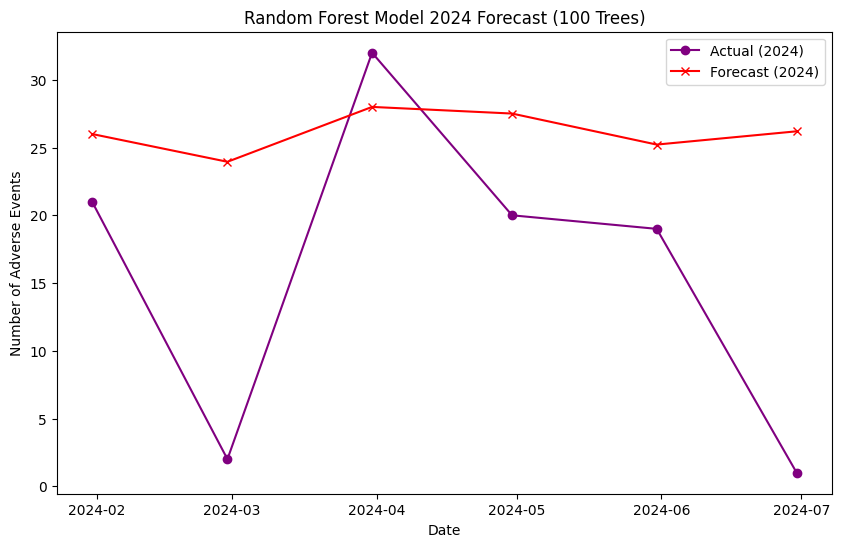

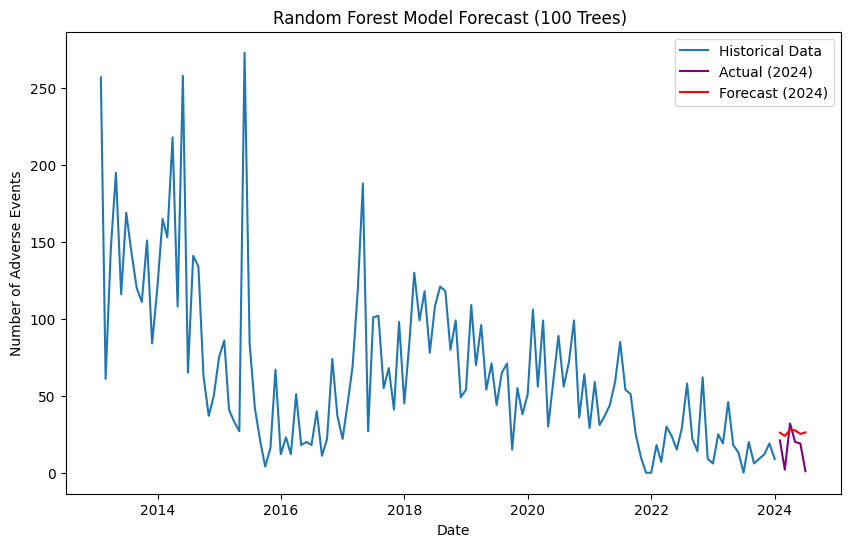

In [33]:
# Plot Actual vs Predicted for Partial 2024
plt.figure(figsize=(10, 6))
plt.plot(y_partial_2024.index, y_partial_2024, label='Actual (2024)', marker='o', color='purple')
plt.plot(y_partial_2024.index, y_pred_partial_2024, label='Forecast (2024)', marker='x', color='red')
plt.title(f'Random Forest Model 2024 Forecast ({Trees} Trees)')
plt.xlabel('Date')
plt.ylabel('Number of Adverse Events')
plt.legend()
plt.show()

# Visualize Overall Data with Partial 2024 Forecast
plt.figure(figsize=(10, 6))
plt.plot(df_grouped, label='Historical Data')
plt.plot(df24_grouped, label='Actual (2024)', color='purple')
plt.plot(y_partial_2024.index, y_pred_partial_2024, label='Forecast (2024)', color='red')
plt.title(f'Random Forest Model Forecast ({Trees} Trees) ')
plt.xlabel('Date')
plt.ylabel('Number of Adverse Events')
plt.legend()
plt.show()